## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
import torch.nn as nn
import random
from sklearn.metrics import accuracy_score
plt.style.use('dark_background')

### Perceptual decision making

__1. Create a function for generating the data.__

In [2]:
# Defining constants given in the exercise description.
mu = 0
std = 0.03
stim_strengths = lambda data_size: [3.2 / 100 * random.choice(np.array([1, 2, 4, 8, 16])) for i in range(data_size)]

In [3]:
def get_input(u_bar, t_step, mu, std):
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 45:
            u[t] = u_bar + np.random.normal(mu, std)
        else:
            u[t] = np.random.normal(mu, std)
    
    return u

def generate_data(stim_strengths, t_step, mu, std):
    U = np.zeros((len(stim_strengths), t_step))
    y = np.zeros(len(stim_strengths))
    for trial, stim_strength in enumerate(range(len(stim_strengths))):
        u_bar = np.random.uniform(-stim_strengths[trial], stim_strengths[trial])
        U[trial] = get_input(u_bar, t_step, mu, std)
        y[trial] = np.sign(u_bar)
        
    return torch.from_numpy(U), torch.from_numpy(y)

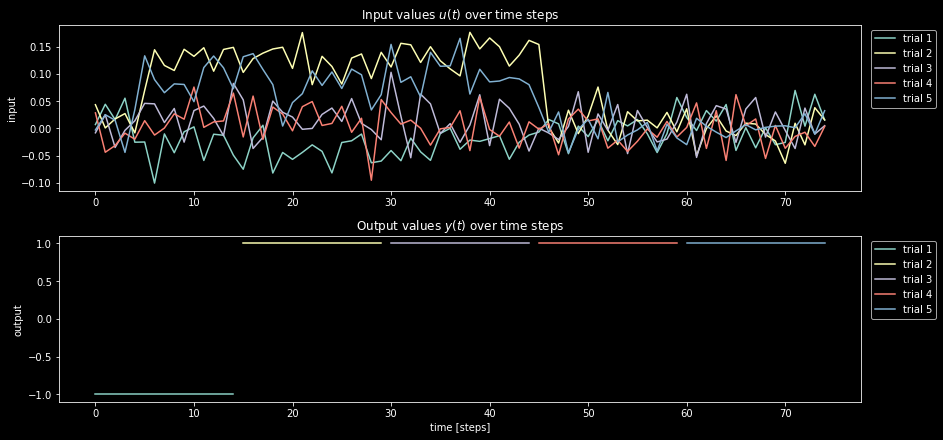

In [4]:
t_steps = 75
U, y = generate_data(stim_strengths(5), t_steps, mu, std)

fig, axs = plt.subplots(2, 1, figsize = (13, 6), constrained_layout = True)
for trial in range(U.shape[0]):
    axs[0].set_title(r'Input values $u(t)$ over time steps')
    axs[0].plot(np.arange(0, t_steps, 1), U[trial], label = f'trial {trial+1}')
    axs[0].set_ylabel('input')
    
    axs[1].set_title(r'Output values $y(t)$ over time steps')
    axs[1].plot(np.arange(trial * t_steps/U.shape[0], (trial+1) * t_steps/U.shape[0], 1), 
                np.full(int(t_steps/U.shape[0]), y[trial]), label = f'trial {trial+1}')
    axs[1].set_ylabel('output')
    axs[1].set_xlabel('time [steps]')

for i in range(2):
    axs[i].legend(loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

In [5]:
# Define the functions.
phi = lambda x: torch.tanh(x)
dynamics = lambda u, x, t, I, J, tau=0.1: (-x + torch.matmul(J, phi(x)) + I*u[:,t]) / tau
output = lambda x, N: 1 / N * w(N)@phi(x)

In [6]:
def forward_euler(u, x, t, I, J, dt=0.02, tau=0.1):
    x = x + dt * dynamics(u, x, t, I, J, tau)
    return x

In [7]:
class RNN(nn.Module):
    '''
    Single custom RNN layer with a low-rank connectivity matrix and a leak term.
    '''
    def __init__(self, input_size, hidden_size, rank):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.m_list = nn.ParameterList([nn.Parameter(torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)) for i in range(rank)])
        self.n_list = nn.ParameterList([nn.Parameter(torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)) for i in range(rank)])

    def forward(self, u, I, t, x):
        m_n = torch.zeros((128, 128))
        for i in range(len(self.m_list)):
            m_n += torch.matmul(self.m_list[i], self.n_list[i].T)
            
        J = 1 / self.hidden_size * m_n
        x = forward_euler(u, x, t, I, J)
        return x

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, rank=1):
        super(Model, self).__init__()
        
        # Define the number of layers and the nodes in each layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rank = rank
        
        # Define and initialize the fixed weights I and w.
        self.I = torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)
        # self.w = torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)
        self.w = torch.normal(torch.zeros(hidden_size, 1), torch.full((hidden_size, 1), 4)).reshape(hidden_size, input_size)
        
        # Define the network layers.
        self.rnn = RNN(input_size, hidden_size, rank)
        
    def forward(self, u, t, x):
        x = self.rnn(u, self.I, t, x).float()
        z = 1 / self.hidden_size * torch.matmul(self.w.T, phi(x))
        
        return x, z

__3. Train a network of size $N = 128$ by minimizing the mean squared error using stochastic gradient descent.__

In [9]:
def train_network(model, U, y, input_size, hidden_size, t_steps, batch_size=32, n_epochs=100, lr=5e-3):
    time_steps = U.shape[1]
    n_batches = int(U.shape[0] / batch_size)
    n_last_steps = 15
    last_steps = t_steps - n_last_steps
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
        
    # x = torch.normal(torch.zeros(hidden_size, batch_size), torch.ones(hidden_size, batch_size))
        
    loss_log = np.zeros(n_epochs)
    x_log = np.zeros((n_epochs, n_batches, hidden_size, batch_size))
    z_log = np.zeros((n_epochs, n_batches, n_last_steps, batch_size))
        
    for epoch in range(1, n_epochs+1):
        epoch_loss = 0
        for batch in range(n_batches):
            x = torch.zeros(hidden_size, input_size)
            for t in range(t_steps):
                x, z = model(U[batch*batch_size:(batch+1)*batch_size], t, x)
                
                # Minimize the loss function over the last 15 time steps.
                if t >= last_steps:
                    loss = mse_loss(z.reshape(batch_size).float(), y[batch*batch_size:(batch+1)*batch_size].float())
                    loss.backward(retain_graph = True)    # Compute the gradients
                    optimizer.step()                      # Parameter updates
                                        
                    model.zero_grad()                     # Clear the gradients
                    x = x.detach()  
                    
                    epoch_loss += loss
                    x_log[epoch-1, batch] = x.numpy()
                    z_log[epoch-1, batch, (last_steps-t)] = z.detach().numpy()
                    
        loss_log[epoch-1] = epoch_loss / (n_last_steps * n_batches)
        if epoch%10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(loss_log[epoch-1]))
            
    return loss_log, x_log, z_log
# https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but

In [10]:
# Generate the data.
N = 128
t_steps = 75
batch_size = 32
n_batches = 5
data_size = batch_size * n_batches

stim_strengths_rnn = stim_strengths(data_size)
U, y = generate_data(stim_strengths_rnn, t_steps, mu, std)

In [11]:
# Define the model.
input_size = 1
hidden_size = N
rank = 1
model = Model(input_size, hidden_size, rank)
model

Model(
  (rnn): RNN(
    (m_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
    (n_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
  )
)

In [12]:
n_epochs = 200
n_last_steps = 20
loss, x_log, z_log = train_network(model, U, y, input_size, hidden_size, t_steps, n_epochs=n_epochs)

Epoch: 10/200............. Loss: 0.1084
Epoch: 20/200............. Loss: 0.1006
Epoch: 30/200............. Loss: 0.0963
Epoch: 40/200............. Loss: 0.0935
Epoch: 50/200............. Loss: 0.0914
Epoch: 60/200............. Loss: 0.0900
Epoch: 70/200............. Loss: 0.0891
Epoch: 80/200............. Loss: 0.0887
Epoch: 90/200............. Loss: 0.0885
Epoch: 100/200............. Loss: 0.0887
Epoch: 110/200............. Loss: 0.0892
Epoch: 120/200............. Loss: 0.0898
Epoch: 130/200............. Loss: 0.0904
Epoch: 140/200............. Loss: 0.0911
Epoch: 150/200............. Loss: 0.0917
Epoch: 160/200............. Loss: 0.0923
Epoch: 170/200............. Loss: 0.0928
Epoch: 180/200............. Loss: 0.0932
Epoch: 190/200............. Loss: 0.0937
Epoch: 200/200............. Loss: 0.0942


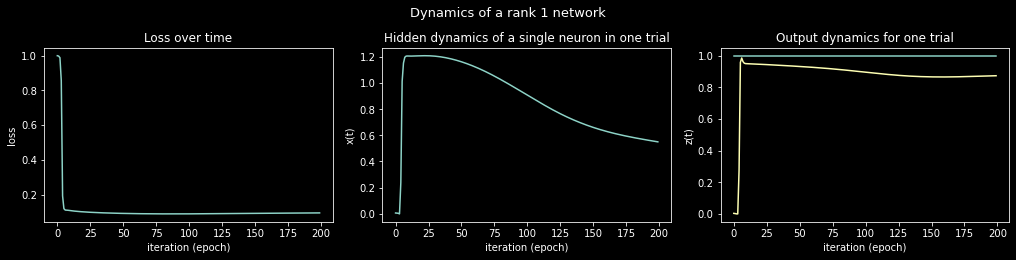

In [13]:
# Plot the loss, hidden and output dynamics.
plots = [loss.flatten(), x_log[:,0,0,0], np.full(n_epochs, y[0]), z_log[:,0,-1,0]]
titles = ['Loss over time', 'Hidden dynamics of a single neuron in one trial', 'Output dynamics for one trial']
y_labels = ['loss', 'x(t)', 'z(t)']

fig, axs = plt.subplots(1, 3, figsize = (14, 3.5), constrained_layout = True)
fig.suptitle(f'Dynamics of a rank {rank} network', fontsize = 13)
for i in range(3):
    axs[i].plot(plots[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('iteration (epoch)')
    axs[i].set_ylabel(y_labels[i])
    if i == 2:
        axs[i].plot(plots[3])
plt.show()

__4. Dubreuil et al. found that their network relied on a specific pattern of correlations between the connectivity vectors (their figure 2b). Explain why this pattern works for the task, and compare it with the pattern in your network.__

Within this framework, each neuron is characterized by its set of _loadings_ corresponding to its input $\mathbf{I}$, readout $\mathbf{w}$ and connectivity patterns $\mathbf{m}$ and $\mathbf{n}$ values. This means that each neuron corresponds to a single point in _loading space_ spanned by the corresponding patterns. Debreuil et al. considered the situation in which _P_ population of neurons correspond to _P_ Gaussian clusters in the loading space. 

A two-dimensional projection of the connectivity patterns $\mathbf{m}$ and $\mathbf{n}$ in the loading space shows a single Gaussian cluster fully characterized by the corresponding correlation matrix. Their work actually revealed that a single, global Gaussian population was sufficient to implement the perceptual decision making task. From this correlation matrix (covariance matrix without variances) they extracted new networks that performed as good as the original trained network. This works because multivariate Gaussian mixture models (GMMs) are used which can approximate arbitrary joint distributions of loadings.

As depicted in the plot below the covariance matrix, the pattern of our network show the same results in the sense that the 2D projections of the loading space show that we have a single Gaussian cluster.

In [14]:
def plt_cov(cov, title):
    fig, ax = plt.subplots()
    fig.canvas.draw()
    
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_xticklabels(['n', 'm', 'w', 'I']) 
    ax.set_yticklabels(['n', 'm', 'w', 'I']) 
    
    im = ax.imshow(cov)
    fig.colorbar(im)
    ax.set_title(title)
    plt.show()

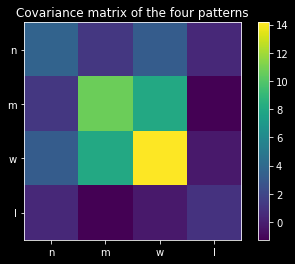

In [15]:
# Statistics of the pattern loadings for a unit rank network after training.
m = model.rnn.m_list[0].detach().numpy().reshape(hidden_size)
n = model.rnn.n_list[0].detach().numpy().reshape(hidden_size)
I = model.I.detach().numpy().reshape(hidden_size)
w = model.w.detach().numpy().reshape(hidden_size)

cov = np.cov(np.array([n, m, w, I]))
plt_cov(cov, 'Covariance matrix of the four patterns')

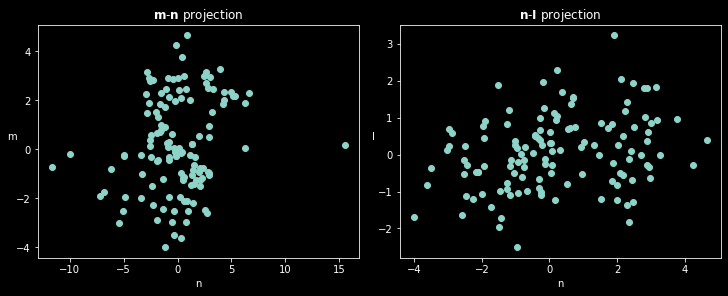

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4), constrained_layout = True)

axs[0].set_title(r'$\mathbf{m}$-$\mathbf{n}$ projection')
axs[0].scatter(m, n)
axs[0].set_xlabel('n')
axs[0].set_ylabel('m', rotation = 'horizontal')

axs[1].set_title(r'$\mathbf{n}$-$\mathbf{I}$ projection')
axs[1].scatter(n, I)
axs[1].set_xlabel('n')
axs[1].set_ylabel('I', rotation = 'horizontal')
plt.show()

__5. The theory of low-rank networks relies on Gaussian approximations, which characterizes connectivity vectors by their second order statis- tics. Test if this assumption holds in your trained network by__
- (1) fitting a 4-dimensional Gaussian distribution to the connectivity vectors, 
- (2) Resampling from the fitted distribution, 
- (3) Comparing the empirical with the resampled distribution, and 
- (4) Testing networks with the resampled connectivity by comparing the sign of the output with the sign of the target.

In [17]:
mu_m = np.mean(m)
mu_n = np.mean(n)
mu_I = np.mean(I)
mu_w = np.mean(w)

mu = np.array([mu_m, mu_n, mu_I, mu_w])

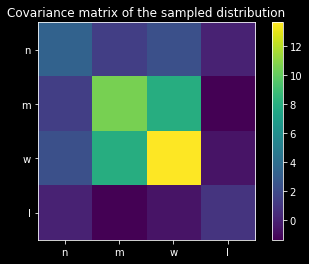

In [18]:
# Fitting and resampling.
sampled_distribution = np.random.multivariate_normal(mu, cov, size = hidden_size)

# Comparing covariance matrices.
cov_sampled = np.cov(sampled_distribution.T)
plt_cov(cov_sampled, 'Covariance matrix of the sampled distribution')

In [19]:
# Test the model with the resampled connectivity.
m_sampled = sampled_distribution[:,0]
n_sampled = sampled_distribution[:,1]
I_sampled = sampled_distribution[:,2]
w_sampled = sampled_distribution[:,3]

# Replacing connectivity patterns in the resampled network with the resampled patterns.
model_sampled = Model(input_size, hidden_size, rank)
model_sampled.rnn.m_list = nn.ParameterList([nn.Parameter(torch.from_numpy(m_sampled.reshape(hidden_size, input_size)).float())])
model_sampled.rnn.n_list = nn.ParameterList([nn.Parameter(torch.from_numpy(n_sampled.reshape(hidden_size, input_size)).float())])
model_sampled.I = torch.from_numpy(I_sampled.reshape(hidden_size, input_size)).float()
model_sampled.w = torch.from_numpy(w_sampled.reshape(hidden_size, input_size)).float()

In [20]:
model_sampled

Model(
  (rnn): RNN(
    (m_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
    (n_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
  )
)

In [21]:
x = torch.zeros(hidden_size, input_size)
for t in range(t_steps):
    x, z = model_sampled(U, t, x)

In [22]:
# Comparing the signs of output and target.
acc_score = accuracy_score(y, torch.sign(z.detach().reshape(U.shape[0])))
print(f'{acc_score}% of the input was classified correctly by the network with resampled connectivity.')

0.9625% of the input was classified correctly by the network with resampled connectivity.
